# HPF: matching requested expectation and variance using SGD

The notebook demonstrates how priors matching requested values of prior predictive expectation and/or variance can be found for Hierarchical Poisson Matrix Factorization model using SGD.

## Setup 


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
tfe = tf.contrib.eager


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
tf.executing_eagerly()

True

In [4]:
import time
import numpy as np
import pandas as pd

In [5]:
from aux import *

# Configuration

In [6]:
args = parse_script_args()

parsing: <-f>


In [7]:
np.random.seed(int(time.time()))
EID = np.random.randint(10000)

In [8]:
SEED = args.get("SEED", 129)
np.random.seed(SEED)

In [9]:
K = args.get("K", 25) # factorization dimensions

In [10]:
NITER = args.get("NITER", 10000) + 1 # how many iterations
LR = args.get("LR", 0.1) # learning rate
LAMBDA = args.get("LAMBDA", 0.0) # regularization

In [11]:
# requested values
DESIRED_EXPECTATION = args.get("E", 25)
DESIRED_VARIANCE = args.get("V", 550)

# discrepancy measure: care about E=only expectation, V=only variance, EV=both
D = args.get("D", "V")
if D=="E": DESIRED_VARIANCE = -1
if D=="V": DESIRED_EXPECTATION = -1
    
discrepancy_expectation = lambda expectation, variance: (expectation-DESIRED_EXPECTATION)**2 
discrepancy_variance    = lambda expectation, variance: (variance-DESIRED_VARIANCE)**2 
discrepancy_exp_var     = lambda expectation, variance: discrepancy_variance(expectation, variance) + \
                                                        discrepancy_expectation(expectation, variance)

NAME2DISCREPANCY = {"E":  discrepancy_expectation, "EV": discrepancy_exp_var, "V": discrepancy_variance}
discrepancy = NAME2DISCREPANCY[D]

In [12]:
# sampling strategy
SAMPLING = args.get("SAMPLING", 0)
if SAMPLING==0 and LAMBDA<=0.0:
    if D=="E": SAMPLING = 2 # if V is not used
    if D=="V": SAMPLING = 3 # if E is not used

NSAMPLES_LATENT = args.get("S", 1000) # how many samples of latent variables
NSAMPLES_OUTPUT = args.get("SY", 10)  # how many samples of outputs for each latent

In [13]:
# optimization initial values 

a0, ap0, bp0 = args.get("a", 3.0), args.get("ap", 3.0), args.get("bp", 1.0)
c0, cp0, dp0 = args.get("c", 3.0), args.get("cp", 3.0), args.get("dp", 1.0)


# which parameter space
PARAMETRIZATION = args.get("TRANSFORMATION", "abcd") # musigma/abcd
# how to transform from unbounded space to a bounded one and vice versa
VARIABLES_TRANSFORMATION = args.get("TRANSFORMATION", "softplus") # softplus/exp
# which of the parameters to train
TRAINABLE = args.get("TRAIN", "012345") 

In [14]:
DESCRIPTION = dict2str(globals()).replace("NSAMPLES", "S").replace("DESIRED_", "").replace("EXPECTATION", "E").replace("VARIANCE", "V").replace("TRAINABLE", "TT")
DESCRIPTION = "a=%s ap=%s bp=%s c=%s cp=%s dp=%s %s" % (a0, ap0, bp0, c0, cp0, dp0,DESCRIPTION)
print("DESCRIPTION: %s" % DESCRIPTION)

ID = str(args.get("ID", DESCRIPTION))

DESCRIPTION: a=3.0 ap=3.0 bp=1.0 c=3.0 cp=3.0 dp=1.0 D=V E=-1 V=550 EID=3343 K=25 LAMBDA=0.0 LR=0.1 NITER=10001 S_LATENT=1000 S_OUTPUT=10 PARAMETRIZATION=abcd SAMPLING=3 SEED=129 TT=012345 VARIABLES_TRANSFORMATION=softplus


# Parameters transformation

For HPF, we consider only one parametrization (the one from the original paper),
so the parametrization is an identity.
However, we still need to perform a transformation from unconstrained space.

In [15]:
def abcdef2abcdef(a, b, c, d, e, f, env=tf):    
    return a, b, c, d, e, f

In [16]:
from tensorflow.contrib.distributions import softplus_inverse
#softplus_inverse = lambda v: tf.log(tf.exp(v)-1.0)
NAME2TRANSFORMATION = {"softplus": (tf.nn.softplus, softplus_inverse), "exp": (tf.exp, np.log)}
forward_transformation, backward_transformation = NAME2TRANSFORMATION[VARIABLES_TRANSFORMATION]

print("forward_transformation:=%s backward_transformation:=%s" % 
      (forward_transformation.__name__, backward_transformation.__name__))
#print("  transformation prec:", np.array(backward_transformation(forward_transformation(a0))-a0))

NAME2PARAMETRIZATION = {"abcd": (abcdef2abcdef, abcdef2abcdef)}
forward_parametrization, backward_parametrization = NAME2PARAMETRIZATION[PARAMETRIZATION]

print("forward_parametrization:=%s backward_parametrization:=%s " % 
      (forward_parametrization.__name__, backward_parametrization.__name__))
#print("  parametrization prec:", forward_parametrization(*backward_parametrization(a0,b0,c0,d0))-np.array([a0,b0,c0,d0]))
#assert (np.round(inverse_parametrization(*parametrization(a0,b0,c0,d0))-np.array([a0,b0,c0,d0]),2) ==0).all()

forward_transformation:=softplus backward_transformation:=softplus_inverse
forward_parametrization:=abcdef2abcdef backward_parametrization:=abcdef2abcdef 


# Expectation & variance estimators

In [17]:
from hpf_model import create_moments_estimator
theoretical_moments = create_moments_estimator(K=25, ESTIMATOR_NO=-1)
empirical_moments   = create_moments_estimator(K=25, ESTIMATOR_NO=SAMPLING)
print("empirical_moments := %s" % empirical_moments.__name__)

empirical_moments := empirical_moments_V_decoupled


In [18]:
e, v = theoretical_moments(a0, ap0, bp0, c0, cp0, dp0)
print("Initialization: a=%.3f\tap=%.3f\tbp=%.3f\ta=%.3f\tap=%.3f\tbp=%.3f\t=> E=%.4f \tV=%.4f" % 
      (a0, ap0, bp0, c0, cp0, dp0, e, v))

Initialization: a=3.000	ap=3.000	bp=1.000	a=3.000	ap=3.000	bp=1.000	=> E=505.8573 	V=722606.8320


# Find hyperparameters matching desired values

In [19]:
tf.random.set_random_seed(SEED)
np.random.seed(SEED)

In [20]:
# init (unbounded) params
float2 = lambda v: tf.Variable(v, dtype=tf.float64)

a0tf, ap0tf, bp0tf, c0tf, cp0tf, dp0tf = float2(a0), float2(ap0), float2(bp0), float2(c0), float2(cp0), float2(dp0)
i0, i1, i2, i3, i4, i5 = backward_parametrization(a0tf, ap0tf, bp0tf, c0tf, cp0tf, dp0tf, env=tf)

p0u = tf.Variable(backward_transformation(i0), name="0", dtype=tf.float64) 
p1u = tf.Variable(backward_transformation(i1), name="1", dtype=tf.float64) 
p2u = tf.Variable(backward_transformation(i2), name="2", dtype=tf.float64) 
p3u = tf.Variable(backward_transformation(i3), name="3", dtype=tf.float64) 
p4u = tf.Variable(backward_transformation(i4), name="4", dtype=tf.float64) 
p5u = tf.Variable(backward_transformation(i5), name="5", dtype=tf.float64) 

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
trainable_variables = [var for var in [p0u, p1u, p2u, p3u, p4u, p5u] if var.name.split(":")[0] in TRAINABLE]
optimizer = tf.train.AdamOptimizer(learning_rate=LR)
start = time.time()
computation_time = 0.0
results = []

In [22]:
best_loss = float("inf")
best_hyperparameters = -1.0, -1.0, -1.0, -1.0, -1.0, -1.0
best_E, best_V = -1.0, -1.0

In [23]:
for iteration in range(NITER):
  
    ##########################################################################################################
    # Optimization
    iteration_start_time = time.time()
        
    with tf.GradientTape() as tape:        
        p0,p1,p2 = forward_transformation(p0u), forward_transformation(p1u), forward_transformation(p2u)  
        p3,p4,p5 = forward_transformation(p3u), forward_transformation(p4u), forward_transformation(p5u)  
        
        a, ap, bp, c, cp, dp =  forward_parametrization(p0,p1,p2,p3,p4,p5)           
        expectation, variance = empirical_moments(a, ap, bp, c, cp, dp, NSAMPLES_LATENT, NSAMPLES_OUTPUT)        
        loss = discrepancy(expectation, variance) -(LAMBDA*variance if LAMBDA>0 else 0.0) # just to be sure
    
    grads = tape.gradient(loss, trainable_variables)              
    optimizer.apply_gradients(zip(grads, trainable_variables), global_step=tf.train.get_or_create_global_step())
    computation_time += (time.time()-iteration_start_time)
    
    if loss<best_loss: #TODO Can do better by evaluating here the loss with more samples
        #print("%i/%i: best: old=%.2f new=%.2f" % (iteration, NITER, best_loss, loss.numpy()))
        best_loss = loss.numpy()
        best_hyperparameters = a.numpy(), ap.numpy(), bp.numpy(), c.numpy(), cp.numpy(), dp.numpy()
        
    ##########################################################################################################
    # Reporting:
    failed = not is_valid(np.array(expectation))
    elapsed = time.time() - start
    if (failed) or (iteration%10==0 and iteration<100) or (iteration%50==0): 
        eval_start = time.time()
        best_E, best_V = theoretical_moments(*best_hyperparameters)
        expectation_exact, variance_exact = theoretical_moments(a, ap, bp, c, cp, dp)        
        
        r = (ID, D, SEED,
             a0, ap0, bp0, c0, cp0, dp0, NITER, LR,
             K, NSAMPLES_LATENT, NSAMPLES_OUTPUT, 
             DESIRED_EXPECTATION, DESIRED_VARIANCE, LAMBDA,
             ((NITER-1) if failed else iteration), computation_time, 
             a.numpy(), ap.numpy(), bp.numpy(), c.numpy(), cp.numpy(), dp.numpy(),
             loss.numpy(), expectation_exact, variance_exact, expectation.numpy(), variance.numpy(),
             best_loss, *best_hyperparameters, best_E, best_V,
             failed)
        results.append(r)

    #if (failed) or (iteration<10) or (iteration<1000 and iteration%100==0)  or (iteration%1000==0):         
        print("[%.2f][%.2f] best:\tloss:%.1f\thyperparams: a=%.3f ap=%.3f bp=%.3f a=%.3f ap=%.3f bp=%.3f => E=%.3f V=%.3f" % 
              (computation_time, elapsed, best_loss, *best_hyperparameters, best_E, best_V))        
        print("[%.2f][%.2f] %i/%i,\tloss:%.1f\thyperparams: a=%.3f ap=%.3f bp=%.3f a=%.3f ap=%.3f bp=%.3f" % 
              (computation_time, elapsed, iteration, NITER, loss.numpy(), 
               a.numpy(), ap.numpy(), bp.numpy(), c.numpy(), cp.numpy(), dp.numpy()))                
        print(" empirical: E: %.2f V: %.2f" % (expectation, variance) )    
        print(" theoretic: E: %.2f V: %.2f" % (expectation_exact, variance_exact) )
        print(" desired: E: %.2f V: %.2f (eval time=%.2f)" % (DESIRED_EXPECTATION, DESIRED_VARIANCE, time.time()-eval_start) )                
        sys.stdout.flush()

    if failed:
        print("Error: ran into invalid values!")
        break

[0.14][0.17] best:	loss:647613406535.7	hyperparams: a=3.000 ap=3.000 bp=1.000 a=3.000 ap=3.000 bp=1.000 => E=505.957 V=723063.955
[0.14][0.17] 0/10001,	loss:647613406535.7	hyperparams: a=3.000 ap=3.000 bp=1.000 a=3.000 ap=3.000 bp=1.000
 empirical: E: 486.89 V: 805294.31
 theoretic: E: 506.23 V: 827837.66
 desired: E: -1.00 V: 550.00 (eval time=9.05)
[0.64][9.73] best:	loss:3167093702.3	hyperparams: a=2.582 ap=3.421 bp=1.299 a=2.581 ap=3.419 bp=1.299 => E=196.991 V=78438.884
[0.64][9.73] 10/10001,	loss:3458366920.1	hyperparams: a=2.525 ap=3.478 bp=1.343 a=2.523 ap=3.477 bp=1.343
 empirical: E: 165.15 V: 59357.88
 theoretic: E: 174.14 V: 56665.62
 desired: E: -1.00 V: 550.00 (eval time=9.04)
[1.16][19.29] best:	loss:315203637.4	hyperparams: a=2.478 ap=3.525 bp=1.379 a=2.477 ap=3.525 bp=1.379 => E=156.995 V=44078.940
[1.16][19.29] 20/10001,	loss:317019294.3	hyperparams: a=2.357 ap=3.649 bp=1.473 a=2.355 ap=3.648 bp=1.473
 empirical: E: 115.53 V: 18355.04
 theoretic: E: 121.05 V: 24623.73

[50.31][278.33] best:	loss:681733.4	hyperparams: a=1.919 ap=4.131 bp=1.749 a=1.913 ap=4.030 bp=1.749 => E=52.687 V=3682.702
[50.31][278.33] 800/10001,	loss:5910104.7	hyperparams: a=1.895 ap=4.155 bp=1.762 a=1.889 ap=4.049 bp=1.762
 empirical: E: 50.02 V: 2981.07
 theoretic: E: 50.39 V: 3313.37
 desired: E: -1.00 V: 550.00 (eval time=9.38)
[53.32][290.72] best:	loss:681733.4	hyperparams: a=1.919 ap=4.131 bp=1.749 a=1.913 ap=4.030 bp=1.749 => E=52.579 V=3610.337
[53.32][290.72] 850/10001,	loss:12589292.5	hyperparams: a=1.892 ap=4.157 bp=1.764 a=1.885 ap=4.051 bp=1.764
 empirical: E: 48.24 V: 4098.14
 theoretic: E: 50.09 V: 3262.39
 desired: E: -1.00 V: 550.00 (eval time=9.63)
[56.41][303.44] best:	loss:666027.6	hyperparams: a=1.890 ap=4.158 bp=1.765 a=1.884 ap=4.052 bp=1.765 => E=49.967 V=3227.218
[56.41][303.44] 900/10001,	loss:4209182.7	hyperparams: a=1.888 ap=4.159 bp=1.766 a=1.881 ap=4.054 bp=1.766
 empirical: E: 51.33 V: 2601.63
 theoretic: E: 49.79 V: 3299.63
 desired: E: -1.00 V: 

[125.37][596.80] best:	loss:10283.8	hyperparams: a=1.857 ap=4.184 bp=1.785 a=1.849 ap=4.089 bp=1.785 => E=46.864 V=2946.670
[125.37][596.80] 2000/10001,	loss:3495931.8	hyperparams: a=1.792 ap=4.216 bp=1.819 a=1.782 ap=4.138 bp=1.819
 empirical: E: 41.00 V: 2419.74
 theoretic: E: 41.78 V: 2246.41
 desired: E: -1.00 V: 550.00 (eval time=9.77)
[128.82][610.03] best:	loss:10283.8	hyperparams: a=1.857 ap=4.184 bp=1.785 a=1.849 ap=4.089 bp=1.785 => E=46.808 V=2768.164
[128.82][610.03] 2050/10001,	loss:1611366.6	hyperparams: a=1.785 ap=4.220 bp=1.822 a=1.775 ap=4.144 bp=1.822
 empirical: E: 41.59 V: 1819.40
 theoretic: E: 41.22 V: 2130.32
 desired: E: -1.00 V: 550.00 (eval time=10.03)
[131.85][623.10] best:	loss:10283.8	hyperparams: a=1.857 ap=4.184 bp=1.785 a=1.849 ap=4.089 bp=1.785 => E=46.875 V=2876.448
[131.85][623.10] 2100/10001,	loss:646207.3	hyperparams: a=1.774 ap=4.232 bp=1.828 a=1.764 ap=4.150 bp=1.828
 empirical: E: 39.79 V: 1353.87
 theoretic: E: 40.42 V: 2187.41
 desired: E: -1.0

[209.29][916.72] best:	loss:532.5	hyperparams: a=1.731 ap=4.259 bp=1.851 a=1.718 ap=4.177 bp=1.851 => E=37.206 V=1731.588
[209.29][916.72] 3200/10001,	loss:76421.3	hyperparams: a=1.697 ap=4.282 bp=1.868 a=1.683 ap=4.201 bp=1.868
 empirical: E: 34.63 V: 826.44
 theoretic: E: 35.00 V: 1517.94
 desired: E: -1.00 V: 550.00 (eval time=9.06)
[212.49][928.99] best:	loss:532.5	hyperparams: a=1.731 ap=4.259 bp=1.851 a=1.718 ap=4.177 bp=1.851 => E=37.237 V=1714.181
[212.49][928.99] 3250/10001,	loss:2457752.2	hyperparams: a=1.686 ap=4.287 bp=1.874 a=1.672 ap=4.217 bp=1.874
 empirical: E: 34.56 V: 2117.72
 theoretic: E: 34.31 V: 1468.54
 desired: E: -1.00 V: 550.00 (eval time=9.12)
[215.55][941.17] best:	loss:532.5	hyperparams: a=1.731 ap=4.259 bp=1.851 a=1.718 ap=4.177 bp=1.851 => E=37.328 V=1731.081
[215.55][941.17] 3300/10001,	loss:861434.3	hyperparams: a=1.684 ap=4.289 bp=1.875 a=1.669 ap=4.219 bp=1.875
 empirical: E: 33.44 V: 1478.13
 theoretic: E: 34.17 V: 1424.78
 desired: E: -1.00 V: 550.0

[287.33][1229.09] best:	loss:8.3	hyperparams: a=1.643 ap=4.308 bp=1.896 a=1.628 ap=4.248 bp=1.896 => E=31.779 V=1250.754
[287.33][1229.09] 4450/10001,	loss:570241.0	hyperparams: a=1.608 ap=4.332 bp=1.913 a=1.593 ap=4.272 bp=1.913
 empirical: E: 29.74 V: 1305.14
 theoretic: E: 29.69 V: 1081.09
 desired: E: -1.00 V: 550.00 (eval time=8.94)
[289.84][1240.54] best:	loss:8.3	hyperparams: a=1.643 ap=4.308 bp=1.896 a=1.628 ap=4.248 bp=1.896 => E=31.725 V=1296.571
[289.84][1240.54] 4500/10001,	loss:1967.8	hyperparams: a=1.606 ap=4.333 bp=1.914 a=1.591 ap=4.273 bp=1.914
 empirical: E: 30.50 V: 594.36
 theoretic: E: 29.60 V: 1082.28
 desired: E: -1.00 V: 550.00 (eval time=8.92)
[292.36][1251.98] best:	loss:8.3	hyperparams: a=1.643 ap=4.308 bp=1.896 a=1.628 ap=4.248 bp=1.896 => E=31.721 V=1264.299
[292.36][1251.98] 4550/10001,	loss:373481.6	hyperparams: a=1.605 ap=4.334 bp=1.915 a=1.589 ap=4.273 bp=1.915
 empirical: E: 28.65 V: 1161.13
 theoretic: E: 29.55 V: 1094.69
 desired: E: -1.00 V: 550.00 

[409.29][1639.91] best:	loss:0.3	hyperparams: a=1.570 ap=4.359 bp=1.932 a=1.556 ap=4.296 bp=1.932 => E=27.658 V=918.422
[409.29][1639.91] 5700/10001,	loss:19415.9	hyperparams: a=1.542 ap=4.373 bp=1.946 a=1.527 ap=4.319 bp=1.946
 empirical: E: 25.44 V: 689.34
 theoretic: E: 26.17 V: 826.82
 desired: E: -1.00 V: 550.00 (eval time=12.66)
[414.82][1658.10] best:	loss:0.3	hyperparams: a=1.570 ap=4.359 bp=1.932 a=1.556 ap=4.296 bp=1.932 => E=27.701 V=946.691
[414.82][1658.10] 5750/10001,	loss:67194.4	hyperparams: a=1.539 ap=4.375 bp=1.948 a=1.524 ap=4.321 bp=1.948
 empirical: E: 25.84 V: 809.22
 theoretic: E: 26.05 V: 808.28
 desired: E: -1.00 V: 550.00 (eval time=12.66)
[420.36][1676.31] best:	loss:0.3	hyperparams: a=1.570 ap=4.359 bp=1.932 a=1.556 ap=4.296 bp=1.932 => E=27.671 V=931.258
[420.36][1676.31] 5800/10001,	loss:11624.1	hyperparams: a=1.538 ap=4.375 bp=1.948 a=1.523 ap=4.321 bp=1.948
 empirical: E: 26.33 V: 657.81
 theoretic: E: 26.02 V: 834.02
 desired: E: -1.00 V: 550.00 (eval t

[543.66][2089.28] best:	loss:0.0	hyperparams: a=1.522 ap=4.382 bp=1.956 a=1.507 ap=4.330 bp=1.956 => E=25.290 V=781.135
[543.66][2089.28] 6950/10001,	loss:3448.5	hyperparams: a=1.496 ap=4.396 bp=1.969 a=1.480 ap=4.346 bp=1.969
 empirical: E: 22.83 V: 491.28
 theoretic: E: 23.98 V: 690.60
 desired: E: -1.00 V: 550.00 (eval time=12.55)
[548.72][2106.90] best:	loss:0.0	hyperparams: a=1.522 ap=4.382 bp=1.956 a=1.507 ap=4.330 bp=1.956 => E=25.294 V=791.061
[548.72][2106.90] 7000/10001,	loss:405506.1	hyperparams: a=1.495 ap=4.397 bp=1.970 a=1.478 ap=4.347 bp=1.970
 empirical: E: 23.55 V: 1186.79
 theoretic: E: 23.93 V: 689.20
 desired: E: -1.00 V: 550.00 (eval time=12.57)
[554.00][2124.76] best:	loss:0.0	hyperparams: a=1.522 ap=4.382 bp=1.956 a=1.507 ap=4.330 bp=1.956 => E=25.202 V=766.540
[554.00][2124.76] 7050/10001,	loss:16720.3	hyperparams: a=1.494 ap=4.398 bp=1.970 a=1.477 ap=4.348 bp=1.970
 empirical: E: 24.59 V: 420.69
 theoretic: E: 23.92 V: 694.28
 desired: E: -1.00 V: 550.00 (eval 

[672.74][2528.23] best:	loss:0.0	hyperparams: a=1.522 ap=4.382 bp=1.956 a=1.507 ap=4.330 bp=1.956 => E=25.255 V=765.420
[672.74][2528.23] 8200/10001,	loss:7874.8	hyperparams: a=1.430 ap=4.446 bp=2.002 a=1.411 ap=4.406 bp=2.002
 empirical: E: 21.78 V: 461.26
 theoretic: E: 20.99 V: 517.45
 desired: E: -1.00 V: 550.00 (eval time=12.49)
[678.03][2546.01] best:	loss:0.0	hyperparams: a=1.522 ap=4.382 bp=1.956 a=1.507 ap=4.330 bp=1.956 => E=25.229 V=783.198
[678.03][2546.01] 8250/10001,	loss:1650.6	hyperparams: a=1.430 ap=4.446 bp=2.002 a=1.411 ap=4.406 bp=2.002
 empirical: E: 20.20 V: 590.63
 theoretic: E: 20.98 V: 523.34
 desired: E: -1.00 V: 550.00 (eval time=12.51)
[683.28][2563.78] best:	loss:0.0	hyperparams: a=1.522 ap=4.382 bp=1.956 a=1.507 ap=4.330 bp=1.956 => E=25.210 V=762.744
[683.28][2563.78] 8300/10001,	loss:56498.9	hyperparams: a=1.430 ap=4.446 bp=2.002 a=1.411 ap=4.406 bp=2.002
 empirical: E: 20.15 V: 312.31
 theoretic: E: 21.02 V: 519.97
 desired: E: -1.00 V: 550.00 (eval tim

[805.15][2975.03] best:	loss:0.0	hyperparams: a=1.426 ap=4.451 bp=2.004 a=1.406 ap=4.411 bp=2.004 => E=20.830 V=513.587
[805.15][2975.03] 9450/10001,	loss:2451.3	hyperparams: a=1.420 ap=4.460 bp=2.007 a=1.401 ap=4.417 bp=2.007
 empirical: E: 19.38 V: 500.49
 theoretic: E: 20.61 V: 512.23
 desired: E: -1.00 V: 550.00 (eval time=12.79)
[810.26][2992.93] best:	loss:0.0	hyperparams: a=1.426 ap=4.451 bp=2.004 a=1.406 ap=4.411 bp=2.004 => E=20.849 V=529.348
[810.26][2992.93] 9500/10001,	loss:324.9	hyperparams: a=1.421 ap=4.460 bp=2.006 a=1.402 ap=4.417 bp=2.006
 empirical: E: 19.70 V: 531.98
 theoretic: E: 20.64 V: 509.35
 desired: E: -1.00 V: 550.00 (eval time=12.69)
[815.38][3010.75] best:	loss:0.0	hyperparams: a=1.426 ap=4.451 bp=2.004 a=1.406 ap=4.411 bp=2.004 => E=20.790 V=505.973
[815.38][3010.75] 9550/10001,	loss:14179.8	hyperparams: a=1.420 ap=4.460 bp=2.007 a=1.401 ap=4.419 bp=2.007
 empirical: E: 21.77 V: 430.92
 theoretic: E: 20.57 V: 504.03
 desired: E: -1.00 V: 550.00 (eval time

In [24]:
path = ID+".csv"
print("Saving results to: %s" % path)
df = pd.DataFrame(results)
CN = ["ID", "D", "SEED", "a0", "ap0", "bp0", "c0", "cp0", "dp0", "NITER", "LR", "K", "S", "SY", "E", "V", "LAMBDA",
      "iteration", "elapsed", "a", "ap", "bp", "c", "cp", "dp", "loss", "Et", "Vt", "Ee", "Ve", 
      "best_loss", "best_a", "best_ap", "best_bp", "best_c", "best_cp", "best_dp", "best_E", "best_V", "failed"]
df.rename(columns=dict(enumerate(CN)), inplace=True)
df.to_csv(path, header=True, index=False);

Saving results to: a=3.0 ap=3.0 bp=1.0 c=3.0 cp=3.0 dp=1.0 D=V E=-1 V=550 EID=3343 K=25 LAMBDA=0.0 LR=0.1 NITER=10001 S_LATENT=1000 S_OUTPUT=10 PARAMETRIZATION=abcd SAMPLING=3 SEED=129 TT=012345 VARIABLES_TRANSFORMATION=softplus.csv


# Visualization

In [25]:
from aux_plt import *
import warnings
warnings.filterwarnings("ignore")

## Convergence analysis

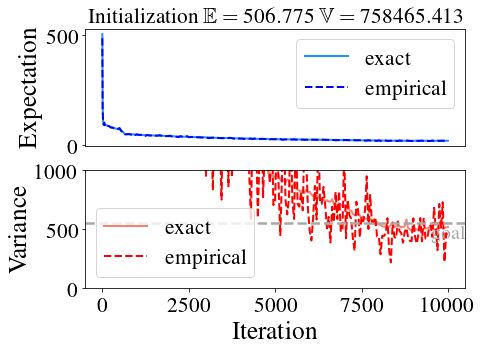

In [26]:
  start_plotting(cmbright=False)
  ax2 = plt.subplot(212)
  ax1 = plt.subplot(211)

  means = df.groupby(["iteration"]).mean().reset_index()
  stds = df.groupby(["iteration"]).std().reset_index()
  assert (means.iteration == stds.iteration).all()
  iteration = means.iteration
    
  e, var = theoretical_moments(a0, ap0, bp0, c0, cp0, dp0)
  plt.title(r"Initialization $\mathbb{E}=%.3f$ $\mathbb{V}=%.3f$" % (e, var))
    
  plt.sca(ax1)
  errorfill((iteration), (means["Et"]), (stds["Et"]), color="dodgerblue", 
            alpha_fill=0.1, label="exact", smooth=0)
  errorfill((iteration), (means["Ee"]), (stds["Ee"]), color="blue", 
            alpha_fill=0.1, label="empirical", smooth=0, ls="--")
  plt.sca(ax2)
  errorfill((iteration), (means["Vt"]), (stds["Vt"]), color="salmon", 
            alpha_fill=0.1, label="exact", smooth=0)
  errorfill((iteration), (means["Ve"]), (stds["Ve"]), color="red", 
            alpha_fill=0.1, label="empirical", smooth=0, ls="--")

  plt.sca(ax2)
  plt.xlabel("Iteration")
  plt.ylabel(r"Variance")
  goal = means["V"][0]
  if goal>-1:
    x1,x2 = plt.xlim()
    plt.axhline(goal, lw=2.5, color="darkgray", ls="--")
    plt.text(x2,goal, r"goal $~$", va="top", ha="right", fontsize=20, color="darkgray")
  plt.legend()
  plt.ylim(0,1000)
  
  plt.sca(ax1)
  plt.legend()
  plt.xticks([],[])
  plt.ylabel(r"Expectation")
  goal = means["E"][0]
  if goal>-1:
    x1,x2 = plt.xlim()
    plt.axhline(goal, lw=2.5, color="darkgray", ls="--")
    plt.text(x2,goal, r"goal $~$", va="top", ha="right", fontsize=20, color="darkgray")
    
  plt.show()

## The best value(s) found up to certain iteration

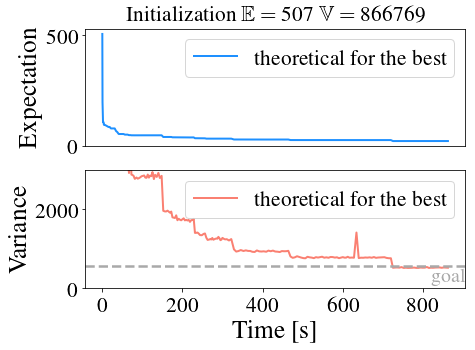

In [27]:
  start_plotting(cmbright=False)
  ax2 = plt.subplot(212)
  ax1 = plt.subplot(211)

  means = df.groupby(["iteration"]).mean().reset_index()
  stds = df.groupby(["iteration"]).std().reset_index()
  assert (means.iteration == stds.iteration).all()
  #xs = means.iteration; xlabel = "Iteration" # Iteration on horizontal axis
  xs = means.elapsed; xlabel = "Time [s]" # Time on horizontal axis
    
  e, var = theoretical_moments(a0, ap0, bp0, c0, cp0, dp0)
  plt.title(r"Initialization $\mathbb{E}=%.0f$ $\mathbb{V}=%.0f$" % (e, var))
    
  plt.sca(ax1)
  errorfill((xs), (means["best_E"]), (stds["best_E"]), color="dodgerblue", 
            alpha_fill=0.1, label="theoretical for the best", smooth=0)
  plt.sca(ax2)
  errorfill((xs), (means["best_V"]), (stds["best_V"]), color="salmon", 
            alpha_fill=0.1, label="theoretical for the best", smooth=0)

  plt.sca(ax2)      
  plt.xlabel(xlabel)
  plt.ylabel(r"Variance")
  goal = means["V"][0]
  if goal>-1:
    x1,x2 = plt.xlim()
    plt.axhline(goal, lw=2.5, color="darkgray", ls="--")
    plt.text(x2,goal, r"goal $~$", va="top", ha="right", fontsize=20, color="darkgray")
  plt.legend()
  plt.ylim(0,3000)
    
  
  plt.sca(ax1)
  plt.legend()
  plt.xticks([],[])
  plt.ylabel(r"Expectation")
  goal = means["E"][0]
  if goal>-1:
    x1,x2 = plt.xlim()
    plt.axhline(goal, lw=2.5, color="darkgray", ls="--")
    plt.text(x2,goal, r"goal $~$", va="top", ha="right", fontsize=20, color="darkgray")
    
  plt.show()

## Hyperameters' values during optimization

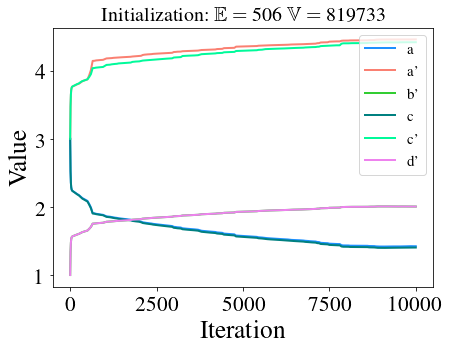

In [28]:
  start_plotting(cmbright=False)
  
  means = df.groupby(["iteration"]).mean().reset_index()
  stds = df.groupby(["iteration"]).std().reset_index()
  assert (means.iteration == stds.iteration).all()
  iteration = means.iteration  
  
  e, var = theoretical_moments(a0, ap0, bp0, c0, cp0, dp0)
  plt.title(r"Initialization: $\mathbb{E}=%.0f$ $\mathbb{V}=%.0f$" % (e, var), fontsize=20)
  
  errorfill((iteration), (means["a"]), (stds["a"]), color=COLORS[0], alpha_fill=0.2, smooth=0, ls="-", label="a")
  errorfill((iteration), (means["ap"]), (stds["ap"]), color=COLORS[1], alpha_fill=0.2, smooth=0, ls="-", label="a'")
  errorfill((iteration), (means["bp"]), (stds["bp"]), color=COLORS[2], alpha_fill=0.2, smooth=0, ls="-", label="b'")
  errorfill((iteration), (means["c"]), (stds["c"]), color=COLORS[3], alpha_fill=0.2, smooth=0, ls="-", label="c")
  errorfill((iteration), (means["cp"]), (stds["cp"]), color=COLORS[4], alpha_fill=0.2, smooth=0, ls="-", label="c'")
  errorfill((iteration), (means["dp"]), (stds["dp"]), color=COLORS[5], alpha_fill=0.2, smooth=0, ls="-", label="d'")

  plt.legend(fontsize=15)  
  plt.xlabel("Iteration")
  plt.ylabel("Value")
  plt.show()  